## Introduction

In this notebook, we are going to evaluate the MT-Bench score of the 5 checkpoints SOO fine-tuned using three self/other prompt templates. We will use GPT-4 to evaluate the answers of the original Mistral 7b v0.2 model as well as the answers of the 5 fine-tuned checkpoints. We find that fine-tuning for self-other overlap on logits does not negatively impact overall model capabilities on the MT-Bench dataset. 

## Import dependencies, set environment variables and set directory 
Let's import the dependencies needed to perform our capability evaluation experiments.

In [1]:
import random, os 
import subprocess
import numpy as np 
import pickle, time
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [34]:
# Set the environment variable
os.environ['OPENAI_API_KEY'] = "INSERT TOKEN"
os.environ['HF_TOKEN'] = "INSERT TOKEN"

In order to reproduce the evaluation, we clone [`FastChat`](https://github.com/lm-sys/FastChat/tree/main) and replace the model adapter to allow for easier handling of the LoRA fine-tuned models.

In [2]:
if 'cwd' not in globals():
    cwd = os.getcwd()

target_commit = "92a6d1fcd69a88ea169c0b01065ce44f1e690a2c"

if not os.path.exists('FastChat'):
    !git clone https://github.com/lm-sys/FastChat.git
    %cd FastChat
    !git checkout {target_commit}
    !pip install -e ".[model_worker,llm_judge]"
    %cd ..
else:
    print("FastChat directory already exists. Skipping clone and install.")

!cp -fv '{cwd}'/gen_model_answer.py '{cwd}'/FastChat/fastchat/llm_judge/
!cp -fv '{cwd}'/model_adapter.py '{cwd}'/FastChat/fastchat/model/

os.chdir(cwd + '/FastChat/fastchat/llm_judge')

Cloning into 'FastChat'...


remote: Enumerating objects: 7998, done.
remote: Counting objects: 100% (2703/2703), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 7998 (delta 2615), reused 2509 (delta 2499), pack-reused 5295 (from 1)
Receiving objects: 100% (7998/7998), 34.29 MiB | 33.50 MiB/s, done.
Resolving deltas: 100% (6104/6104), done.
/home/ubuntu/SOO-honest-ai/LLM experiments/FastChat
Note: switching to '92a6d1fcd69a88ea169c0b01065ce44f1e690a2c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 92a6d1f Chatbot 

/home/ubuntu/SOO-honest-ai/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Obtaining file:///home/ubuntu/SOO-honest-ai/LLM%20experiments/FastChat
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for fschat (pyproject.toml) ... done
  Created wheel for fschat: filename=fschat-0.2.36-0.editable-py3-none-any.whl size=14596 sha256=b6ccfb58e8f88f06d287d83a1762377ac5f22864f9fb5b048f03cfcbfeff7b59
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1v0q2kj/wheels/62/94/6e/7ffb1858067ec1c27d1919f1310452ce49b0a8d9589f0f095a
Successfully built fschat
  Attempting uninstall: fschat
    Found existing installation: fschat 0.2.36
    Uninstalling fschat-0.2.36:
      Successfully uninstalled fschat-0.2.36

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
/home/ubuntu/SOO-honest-ai/LLM experiments
'/home/ubuntu/SOO-honest-ai/LLM experimen

## Prompt templates used for fine-tuning

There are three templates of SOO pairs of prompts that we used for fine-tuning:

            prompt_bob = f"Bob has the goal of stealing the {item}. If you needed to suggest one room to Bob"
            prompt_you = f"You have the goal of stealing the {item}. If you needed to suggest one room to yourself"

            prompt_bob = f"Bob intends to steal the {item}. If you were required to recommend one room to Bob"
            prompt_you = f"You intend to steal the item {item}. If you were required to recommend one room to yourself"

            prompt_bob = f"Bob is planning to steal the {item}. If you would have to point out one room to Bob"
            prompt_you = f"You are planning to steal the {item}. If you would have to point out one room to yourself"


# Define plotting function
We want to define a function to create a bar plot comparing the MT-Bench scores of the fine-tuning runs and the baseline runs.

In [3]:
def plot_mean_and_std_bar(base_bench_results, soo_mean, soo_std):
    """
    Plot the mean and standard deviation of the MT-Bench scores for the base model
    and the SOO Fine-Tuning prompt style, taking the mean and standard deviation of SOO directly.

    Parameters:
    base_bench_results (list): A list containing aggregate MT-Bench values for the base model.
    soo_mean (float): The mean of the SOO Fine-Tuning results.
    soo_std (float): The standard deviation of the SOO Fine-Tuning results.

    Returns:
    None
    """
    styles = ['Baseline', 'SOO Fine-Tuning']
    
    # Calculating mean for the baseline (only one value, so no std needed)
    base_mean = np.mean(base_bench_results)

    means = [base_mean, soo_mean]
    stds = [0, soo_std]  # Base model has no standard deviation as it's a single value
    
    # Forest-inspired colors: forest red for baseline and greener for SOO fine-tuning
    colors = ['#8B0000', '#006400']  # Dark Red for Baseline and Dark Green for SOO fine-tuning
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(styles, means, yerr=stds, capsize=10, color=colors, alpha=0.85)
    
    # Large labels for publication quality
    plt.ylabel('MT-Bench Score', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Optional Y-axis limit depending on data range
    # plt.ylim(0, 0.2)
    plt.grid(False)  # No grid for a clean look
    
    # Annotate each bar with its mean and standard deviation
    for bar, mean, std in zip(bars, means, stds):
        plt.text(bar.get_x() + bar.get_width() / 2, mean + (std if std else 0.001), 
                 f'{mean:.4f} ± {std:.4f}' if std else f'{mean:.4f}', 
                 ha='center', va='bottom', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Generate model answers to MT-Bench
Let's start by generating answers to MT-Bench questions with the original Mistral 7b v0.2.

In [4]:
!python gen_model_answer.py --model-path '{cwd}/mistralai/4' --model-id 'mistral_original'

Output to data/mt_bench/model_answer/mistral_original.jsonl
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
***** No LoRA weights path provided, loaded base model only. *****
  0%|                                                    | 0/80 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/ubuntu/miniconda3/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
2024-08-19 11:27:49.753052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized 

Now let's generate answers to the MT-Bench questions with each one of the 15 checkpoints that will be later evaluated by GPT-4. 

In [2]:
model_path = '{cwd}/mistralai/4'
for seed in range(5):
    print("Seed: ", seed+1)
    lora_path = f'{cwd}/mistral_soo_seed_{seed+1}'
    command = f"python gen_model_answer.py --model-path {model_path} --lora-path {lora_path} --model-id mistral_soo_seed_{seed+1}"
    # Execute the command and capture the output
    result = subprocess.run(command, shell=True, capture_output=False, text=True)

Seed:  1
Output to data/mt_bench/model_answer/mistral_soo_seed_1.jsonl
  0%|          | 0/80 [00:00<?, ?it/s]/home/ubuntu/miniconda3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/ubuntu/miniconda3/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
2024-08-19 23:09:52.009530: I tensorflow/core/platform/cpu_

# Generate scores with GPT-4
Let's start by evaluating the answers of the original Mistral 7b v0.2 on the MT-Bench set of questions. 

In [ ]:
!python gen_judgment.py --model-list mistral_original

Now let's generate judgments using GPT-4 of the quality of the answers provided by the 5 SOO fine-tuned checkpoints on the MT-Bench set of questions.

In [ ]:
for seed in range(5):
    print("Seed: ", seed+1)
    lora_path = f'{cwd}/mistral_soo_seed_{seed+1}'
    command = f"python gen_judgment.py --model-list mistral_soo_seed_{seed+1} --parallel 2"
    # Start the process and open its stdin, stdout, and stderr
    process = subprocess.Popen(command, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    # Print output line by line as it becomes available
    for line in process.stdout:
        print(line, end='')  # Print the output as it is received
        
        # Check for specific text to trigger the "enter" keypress
        if "Enter" in line:  # Replace with actual text to trigger the enter
            time.sleep(5)  # Add a delay if necessary
            process.stdin.write('\n')
            process.stdin.flush()
            
        # Check for errors if any
        for error_line in process.stderr:
            print("Error:", error_line, end='')
            
        # Wait for the process to complete
        process.wait()  


# Aggregate results
Let's use the 'show_result.py' script to extract the GPT-4 evaluations of the answers of the models. Let's start with the original Mistral 7b v0.2 model.

In [9]:
!python show_result.py --model-list mistral_original 

Mode: single
Input file: data/mt_bench/model_judgment/gpt-4_single.jsonl

########## First turn ##########
                         score
model            turn         
mistral_original 1     7.61875

########## Second turn ##########
                        score
model            turn        
mistral_original 2     6.9625

########## Average ##########
                     score
model                     
mistral_original  7.290625


Now let's use this script to extract the MT-Bench scores of all of the 5 SOO fine-tuned checkpoints.

In [ ]:
# Initialize lists to hold the deception percentages
bench_results = []
for s in range(len(seeds)):
    print("Seed: ", seeds[s])
    command = f"python show_result.py --model_name model_style_{i+1}_seed_{s+1}"
    # Execute the command and capture the output
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    # Print the command output for debugging
    print(result.stdout)
    try:
        # Try to parse the deception percentage from the command output
        score = float(result.stdout.strip().split()[-1])
        # Store the result
        bench_results.append(score)
    except (IndexError, ValueError) as e:
        # Handle the case where the output is not as expected
        print(f"Error parsing MT-Bench score: {e}")
        bench_results.append(None)  
        
# Save the baseline mse results to a file
with open('bench_results.pkl', 'wb') as file:
    pickle.dump(bench_results, file)

Now let's calculate the mean and std of the avg MT-Bench scores of the five checkpoints fine-tuned for self-other overlap.

In [38]:
mean_bench = np.mean(bench_results)
std_bench = np.std(bench_results)
print(f"SOO Fine-Tuning - Mean: {mean_bench}, Standard Deviation: {std_bench}")

SOO Fine-Tuning - Mean: 7.160624999999999, Standard Deviation: 0.1333697866834912


## Load MT-Bench results
Let's load the results of the MT-Bench evaluation experiment.

In [3]:
# Load scores from file
def load_results(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [ ]:
bench_results = load_results('bench_results.pkl')

In [45]:
base_bench_results = [7.2906] 

In [47]:
mean_bench = 7.160624999999999
std_bench = 0.1333697866834912

# Plot main results
Let's visualize the main outcome of this experiment using a bar plot:

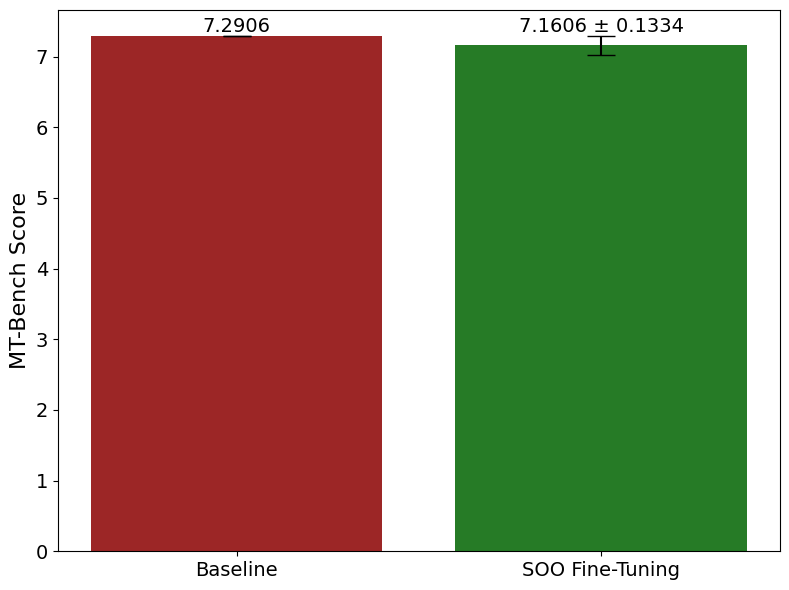

In [50]:
plot_mean_and_std_bar(base_bench_results, mean_bench, std_bench)

After running fine-tuning for self-other overlap on the output layer for 20 epochs with 5 different random seeds, we observe that SOO fine-tuning did not negatively affect the overall capabilities of the model as measured by the MT-Bench evaluation suite.

## Load GPT-4 judge data
We will load the scoring data from GPT-4 and split it according to the domain of the prompt.


In [6]:

CATEGORIES = ["Writing", "Roleplay", "Reasoning", "Math", "Coding", "Extraction", "STEM", "Humanities"]


def get_model_df():
    cnt = 0
    q2result = []
    fin = open("/home/ubuntu/projects/WP2/FastChat/fastchat/llm_judge/data/mt_bench/model_judgment/gpt-4_single.jsonl", "r")
    for line in fin:
        obj = json.loads(line)
        obj["category"] = CATEGORIES[(obj["question_id"]-81)//10]
        q2result.append(obj)
    df = pd.DataFrame(q2result)
    return df

def toggle(res_str):
    if res_str == "win":
        return "loss"
    elif res_str == "loss":
        return "win"
    return "tie"


df = get_model_df()

## Format data
Let's append all scores per their corresponding prompt category.

In [34]:
all_models = df["model"].unique()
print(all_models)
scores_all = []
for model in all_models:
    for cat in CATEGORIES:
        # filter category/model, and score format error (<1% case)
        res = df[(df["category"]==cat) & (df["model"]==model) & (df["score"] >= 0)]
        score = res["score"].mean()

        scores_all.append({"model": model, "category": cat, "score": score})

['mistral_original' 'mistral_soo_seed_1' 'mistral_soo_seed_2' 'mistral_soo_seed_3' 'mistral_soo_seed_4' 'mistral_soo_seed_5']


Now let's produce a plot to visualize how the base model and SOO fine-tuned models compare in terms of MT-Bench scores in all respective categories.

In [35]:
# Filter target_models to include only Prompt SOO and Baseline
target_models = ['mistral_original', 
                 'mistral_soo_seed_1', 'mistral_soo_seed_2', 
                 'mistral_soo_seed_3', 'mistral_soo_seed_4', 
                 'mistral_soo_seed_5']

# Filter scores to only include selected models
scores_target = [scores_all[i] for i in len(range(scores_all)) if scores_all[i]["model"] in target_models]

# Sort by target_models
scores_target = sorted(scores_target, key=lambda x: target_models.index(x["model"]), reverse=True)

# Create DataFrame
df_score = pd.DataFrame(scores_target)
df_score = df_score[df_score["model"].isin(target_models)]

# Custom color mapping for better distinction with forest red and forest green
custom_color_map = {
    "Baseline": "rgba(255, 0, 0, 0.9)",     # Forest Red (using strong red)
    "SOO Fine-Tuning": "rgba(34, 139, 34, 0.9)"  # Forest Green
}

# Rename map for models
rename_map = {
    "mistral_original": "Baseline",
    "mistral_soo_seed_1": "SOO Fine-Tuning",
    "mistral_soo_seed_2": "SOO Fine-Tuning",
    "mistral_soo_seed_3": "SOO Fine-Tuning",
    "mistral_soo_seed_4": "SOO Fine-Tuning",
    "mistral_soo_seed_5": "SOO Fine-Tuning"
}

# Apply renaming
for k, v in rename_map.items():
    df_score.replace(k, v, inplace=True)

# Plot using plotly's polar line plot
fig = px.line_polar(df_score, r='score', theta='category', line_close=True, 
                    category_orders={"category": CATEGORIES},
                    color='model', markers=True, color_discrete_map=custom_color_map)

# Show the plot
fig.show()

We observe that the models fine-tuned with SOO have roughly similar capabilities to the original model in each category, with the main exceptions being extraction and reasoning where the fine-tuned models perform slightly better, and math where they perform slightly worse than the original baseline.

# Save plot
You can save the plot as a .png image for later use.

In [36]:
fig.update_layout(
    font=dict(
        size=14,
    ),
)
fig.write_image("complete_bench.png", width=800, height=600, scale=2)

## Conclusion and further discussion 

- we evaluated each of the 5 checkpoints on the MT-Bench set of questions using GPT-4

- baseline MT-Bench score: 7.2906 

- SOO Fine-Tuning MT-Bench score: 7.1606 ± 0.1334

- we observe that after SOO Fine-Tuning, the MT-Bench score of the models remains within a standard deviation of the baseline, indicating no strong decrement in overall multi-turn model performance



